In [1]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, train_test_split, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from mhcflurry.amino_acid import common_amino_acids
from mhcflurry import dataset
from mhcflurry.dataset import Dataset
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
import statsmodels.api as sm
from keras import models, layers, optimizers
from keras.models import Sequential
from keras.utils.layer_utils import layer_from_config
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology
import seaborn as sns

Using Theano backend.


In [2]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")

df['log_meas']=1-np.log(df['meas'])/math.log(50000)
df['peptide_length'] = df['sequence'].str.len()


max_len=df['sequence'].str.len().max()
n_peptides = df['sequence'].count()

def amino_acid_hotshot_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)
df['hotshot_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_hotshot_encoding(seq))

def amino_acid_index_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])
df['index_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_index_encoding(seq, max_len))

def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000)

df['affinity_label'] = affinity_label(df['log_meas'])
df_h = df[df['mhc']=='HLA-A-0201'][['hotshot_encoded_peptides','index_encoded_peptides','log_meas','peptide_length']]
X = np.array(list(df_h['index_encoded_peptides']))
y = np.array(list(df_h['log_meas']))
y[y<0]=0

In [3]:
ds = Dataset.from_csv("bdata.2009.mhci.public.1.txt")
ds_h = ds.slice(ds.alleles == 'HLA-A0201')

In [4]:
def regroup_together(affinities, weights , original_indices):
    affinities = affinities.ravel()
    weights = weights.ravel()
    assert affinities.shape == weights.shape, "%s should be %s" % (affinities.shape, weights.shape)
    assert affinities.shape == original_indices.shape
    assert len(affinities) == len(affinities.ravel())
    weighted_affinities = (affinities * weights)
    index_set = set(original_indices)
    n_indices = len(index_set)
    result_order = {original_index: i for (i, original_index) in enumerate(sorted(index_set))}
    result = np.zeros(n_indices)
    for i, x in enumerate(weighted_affinities):
        result_idx = result_order[original_indices[i]]
        result[result_idx] += x
    return result

In [5]:
def slicing(dataset,index, i):
    return dataset.slice(index).kmer_index_encoding()[i]
def label_transform(array):
    result = 1-np.log(array)/math.log(50000)
    result[result<0]=0
    return result

In [6]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25

n_epochs = 40
epoch = 0

train_nn_aucs = np.zeros((folds,n_epochs))
test_nn_aucs = np.zeros((folds,n_epochs))

train_lstm_aucs = np.zeros((folds,n_epochs))
test_lstm_aucs = np.zeros((folds,n_epochs))

for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):

    
    nn = Sequential()
    nn.add(Embedding(input_dim = 21, input_length =9, output_dim= 32))
    nn.add(Flatten())
    nn.add(Dense(10, init='glorot_uniform', activation='sigmoid'))
    nn.add(Dense(1, init='glorot_uniform', activation='sigmoid'))
    
    nn.compile(optimizer = 'adam', loss='mean_squared_error')
    
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm = Model(input = sequence, output = output)
    
    lstm.compile(optimizer = 'adam', loss='mean_squared_error')
    
    X_train = slicing(ds_h,train_idx,0)
    y_train = label_transform(slicing(ds_h,train_idx,1))
    
    X_test = slicing(ds_h,test_idx,0)
    y_test = label_transform(slicing(ds_h,test_idx,1))
    
    weights_train = slicing(ds_h,train_idx,2)
    weights_test = slicing(ds_h,test_idx,2)
    
    original_indices_train = slicing(ds_h,train_idx,3)
    original_indices_test = slicing(ds_h,test_idx,3)
    
    train_real_labels = regroup_together(y_train, weights_train , original_indices_train)
    test_real_labels = regroup_together(y_test, weights_test , original_indices_test)
    
    
    for epoch in range(n_epochs):
        # nn
        nn.fit(X_train,y_train, sample_weight = weights_train, batch_size = batch_size_nn, nb_epoch=1)
        
        train_pred_grouped = regroup_together(nn.predict(X_train), weights_train, original_indices_train)
        test_pred_grouped = regroup_together(nn.predict(X_test), weights_test, original_indices_test)
        
        train_nn_auc = roc_auc_score(measured_affinity_less_than(train_real_labels,500), train_pred_grouped)     
        test_nn_auc = roc_auc_score(measured_affinity_less_than(test_real_labels,500), test_pred_grouped)
        
        train_nn_aucs[i][epoch]=train_nn_auc
        test_nn_aucs[i][epoch]=test_nn_auc
        print("NN: ", train_nn_auc, test_nn_auc, epoch)
        #lstm 
        lstm.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    
        
        train_lstm_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm.predict(X[train_idx]))
        test_lstm_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm.predict(X[test_idx]))
        
        train_lstm_aucs[i][epoch]=train_lstm_auc
        test_lstm_aucs[i][epoch]=test_lstm_auc
        print("LSTM: ", train_lstm_auc, test_lstm_auc, epoch)
train_nn_aucs_mean = np.mean(train_nn_aucs, axis=0)
test_nn_aucs_mean = np.mean(test_nn_aucs, axis=0)
train_lstm_aucs_mean=np.mean(train_lstm_aucs, axis=0)
test_lstm_aucs_mean = np.mean(test_lstm_aucs, axis=0)

Epoch 1/1
22026/22026 [==============================] - 1s - loss: 0.0140     
NN:  0.942639462349 0.945951855094 0
Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0615    
LSTM:  0.857153144396 0.865250256634 0
Epoch 1/1
22026/22026 [==============================] - 1s - loss: 0.0088     
NN:  0.949366004227 0.950376173738 1
Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0499    
LSTM:  0.882265730898 0.891871936506 1
Epoch 1/1
22026/22026 [==============================] - 1s - loss: 0.0085     
NN:  0.950907324588 0.951960413991 2
Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0431    
LSTM:  0.928589948812 0.925107874985 2
Epoch 1/1
22026/22026 [==============================] - 1s - loss: 0.0083     
NN:  0.951263198259 0.952395024641 3
Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0337    
LSTM:  0.939379414283 0.936877024739 3
Epoch 1/1
22026/22026 [==============================] - 1s - lo

KeyboardInterrupt: 

In [7]:
embedding_vectors_lstm = lstm.get_weights()[0]
embedding_vectors_nn = nn.get_weights()[0]

# PCA

In [8]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=2)
pca.fit(embedding_vectors_lstm)
embedding_vectors_lstm_pca = pca.transform(embedding_vectors_lstm)
pca = PCA(n_components=2)
pca.fit(embedding_vectors_nn)
embedding_vectors_nn_pca = pca.transform(embedding_vectors_nn)

In [9]:
print(embedding_vectors_lstm_pca, embedding_vectors_nn_pca)

[[ -2.05004394e-01  -1.52585441e-02]
 [ -1.62655279e-01  -8.27258155e-02]
 [  1.83327541e-01  -3.47251803e-01]
 [  4.78743702e-01  -9.65851784e-01]
 [  9.21589315e-01  -6.39510810e-01]
 [ -6.18741512e-01   2.57032782e-01]
 [  3.55817229e-01   2.40515485e-01]
 [  2.73020923e-01   2.91472338e-02]
 [ -6.85900092e-01  -6.02817279e-04]
 [  7.28537440e-01   9.55812931e-01]
 [ -8.28423023e-01  -9.13578421e-02]
 [ -9.08867002e-01   2.03545690e-01]
 [  3.84697169e-01  -3.43704708e-02]
 [  3.45185369e-01  -7.84632266e-01]
 [  5.03924713e-02   2.39964962e-01]
 [  8.12538624e-01   8.23814213e-01]
 [  6.17317967e-02   2.78687686e-01]
 [ -3.88050824e-02   1.44444630e-01]
 [ -3.93592894e-01   1.19517513e-01]
 [ -4.97159421e-01  -5.40318429e-01]
 [ -2.56433070e-01   2.09397122e-01]] [[ -3.10936183e-01   4.53314036e-01]
 [ -7.49904335e-01  -3.33254308e-01]
 [  7.82275856e-01  -1.44683766e+00]
 [  2.56763786e-01  -1.72639740e+00]
 [ -1.34063458e+00   1.76835597e-01]
 [  2.93336064e-01   1.42989517e-03]


In [10]:
dictionary_amino_acids = {integer: amino_acid for (amino_acid, integer) in common_amino_acids.index_dict().items()}

In [11]:
dictionary_amino_acids

{0: 'A',
 1: 'C',
 2: 'D',
 3: 'E',
 4: 'F',
 5: 'G',
 6: 'H',
 7: 'I',
 8: 'K',
 9: 'L',
 10: 'M',
 11: 'N',
 12: 'P',
 13: 'Q',
 14: 'R',
 15: 'S',
 16: 'T',
 17: 'V',
 18: 'W',
 19: 'Y'}

In [12]:
embedding_vectors_lstm_pca.shape

(21, 2)

## PCA on LSTM

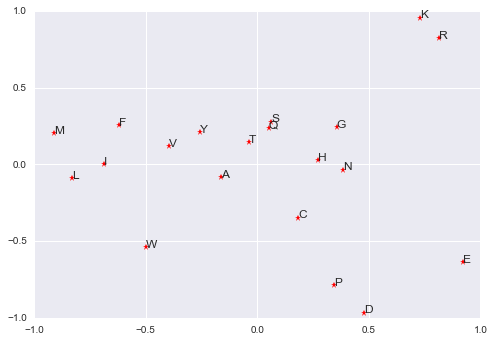

In [13]:
plt.plot(embedding_vectors_lstm_pca[1:,0],embedding_vectors_lstm_pca[1:,1], linestyle='',color= 'r', marker='*')
for i, n in enumerate(embedding_vectors_lstm_pca[1:]):
    plt.annotate(dictionary_amino_acids[i], xy = n)

## PCA on NN

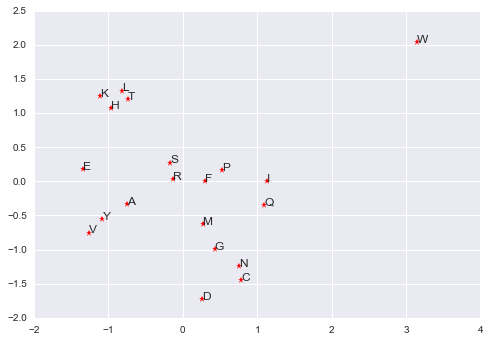

In [17]:
plt.plot(embedding_vectors_nn_pca[1:,0],embedding_vectors_nn_pca[1:,1], linestyle='',color= 'r', marker='*')
for i, n in enumerate(embedding_vectors_nn_pca[1:]):
    plt.annotate(dictionary_amino_acids[i], xy = n)

# T-SNE

In [18]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
embedding_vectors_lstm_tsne = tsne.fit_transform(embedding_vectors_lstm)
tsne = TSNE(random_state=42)
embedding_vectors_nn_tsne = tsne.fit_transform(embedding_vectors_nn)

In [19]:
embedding_vectors_lstm_tsne

array([[  4.95362450e-05,  -1.38131315e-05],
       [  6.43717936e-05,   1.51390775e-04],
       [ -2.33753655e-05,  -2.33742893e-05],
       [  1.57161183e-04,   7.63083870e-05],
       [ -4.68204364e-05,   5.39698125e-05],
       [ -4.62388085e-05,  -4.64803287e-05],
       [  2.41098185e-05,  -1.90803937e-04],
       [ -1.71729957e-04,  -5.61070581e-05],
       [ -1.01037004e-04,   3.11837030e-05],
       [ -9.04890084e-05,  -1.40700222e-04],
       [  1.45746508e-04,  -2.25991841e-05],
       [  6.65268771e-06,  -1.41977317e-04],
       [ -5.43205225e-05,   1.10059292e-05],
       [ -1.14778939e-04,   3.73553865e-05],
       [ -5.99835812e-05,  -2.91351786e-05],
       [ -5.99584039e-05,   1.84127861e-04],
       [ -1.36593070e-06,  -1.05643132e-04],
       [  8.20928674e-05,  -1.21715247e-04],
       [  2.08115538e-05,  -1.95050704e-04],
       [ -1.32464614e-04,   1.96782932e-05],
       [  7.35669920e-05,   1.70280700e-05]])

In [20]:
embedding_vectors_nn_tsne

array([[  4.95593193e-05,  -1.37974415e-05],
       [  6.43241177e-05,   1.51357004e-04],
       [ -2.33890696e-05,  -2.33763668e-05],
       [  1.57117474e-04,   7.63379264e-05],
       [ -4.68048754e-05,   5.40249690e-05],
       [ -4.62380966e-05,  -4.64788780e-05],
       [  2.40911598e-05,  -1.90564844e-04],
       [ -1.71765571e-04,  -5.61069420e-05],
       [ -1.01031237e-04,   3.11827728e-05],
       [ -9.04416036e-05,  -1.40699114e-04],
       [  1.45827388e-04,  -2.25961356e-05],
       [  6.66379127e-06,  -1.42096036e-04],
       [ -5.43167985e-05,   1.10144200e-05],
       [ -1.14849228e-04,   3.73137306e-05],
       [ -5.99504693e-05,  -2.91169820e-05],
       [ -5.99808707e-05,   1.84255302e-04],
       [ -1.42177732e-06,  -1.05513144e-04],
       [  8.18736174e-05,  -1.21705150e-04],
       [  2.08075763e-05,  -1.95262541e-04],
       [ -1.32487133e-04,   1.96200510e-05],
       [  7.35392778e-05,   1.69999419e-05]])

In [21]:
# T-SNE on LSTM 

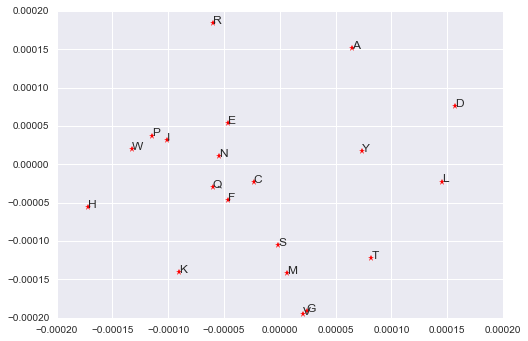

In [22]:
plt.plot(embedding_vectors_lstm_tsne[1:,0],embedding_vectors_lstm_tsne[1:,1], linestyle='',color= 'r', marker='*' )
for i, n in enumerate(embedding_vectors_lstm_tsne[1:]):
    plt.annotate(dictionary_amino_acids[i], xy = n)
plt.show()

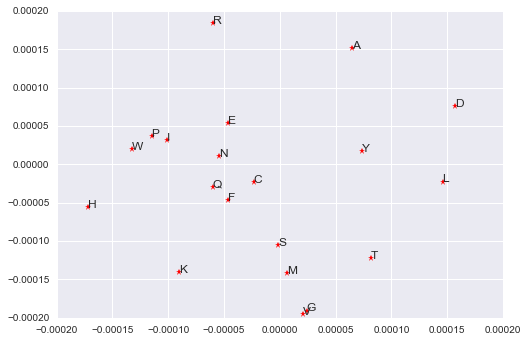

In [23]:
plt.plot(embedding_vectors_nn_tsne[1:,0],embedding_vectors_nn_tsne[1:,1], linestyle='',color= 'r', marker='*' )
for i, n in enumerate(embedding_vectors_nn_tsne[1:]):
    plt.annotate(dictionary_amino_acids[i], xy = n)
plt.show()

In [58]:
dictionary_amino_acids = {integer + 1: amino_acid for (amino_acid, integer) in common_amino_acids.index_dict().items()}

{1: 'A',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'K',
 10: 'L',
 11: 'M',
 12: 'N',
 13: 'P',
 14: 'Q',
 15: 'R',
 16: 'S',
 17: 'T',
 18: 'V',
 19: 'W',
 20: 'Y'}

In [51]:
[k for k in common_amino_acids.index_dict()][2]

'V'

In [55]:
[[i for i in common_amino_acids.index_dict()][k] for k in range(20)]

['D',
 'Y',
 'V',
 'S',
 'R',
 'M',
 'C',
 'L',
 'H',
 'W',
 'K',
 'F',
 'Q',
 'G',
 'I',
 'E',
 'A',
 'T',
 'N',
 'P']

In [50]:
common_amino_acids.index_dict()[k for k in common_amino_acids.index_dict()]

TypeError: unhashable type: 'list'